# HW06
This homework is due Saturday April 13, 2019 at 11:59pm

## Learning Objective:
1. Students must compute and understand the physical extent of images in both `Pixel Corner Centered Regions` and `Pixel Centered Region` interpretations. 
1. Students demonstrate the 2D Euler transform must be computed given corresponding points.
1. Students use python version of ITK to quickly review a large number of scan sessions for quality assurance.


<h1 align="center">Physical Extent In Medical Images</h1>

A critically important feature of ITK as a toolkit for image manipulation and analysis is that it models <b>images as physical objects occupying a bounded region in physical space</b>. In addition, images can have different spacing between pixels along each axis, and the axes are not necessarily aligned with 
the voxel memory orientation. The following figure illustrates these concepts. 

<img src="ImageOriginAndSpacing.png" style="width:700px"/><br><br>

In [3]:
# Boilerplate module inclusions
import itk
itk.force_load()
import numpy as np
import pprint
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed
from ipywidgets import FloatSlider
from itkwidgets import view
from os.path import join

# Read images

Read in images imageA_2d_fn, imageB_2d_fn, imageA_3d_fn, and imageB_3d_fn.

In [2]:
# Image filenames
# NOTE:  The images can be found the class directory `/nfsscratch/opt/ece5490/data`

data_dir='/nfsscratch/opt/ece5490/data'

imageA_2d_fn = 'imageA_2d.nii.gz'
imageB_2d_fn = 'imageB_2d.nii.gz'
imageA_3d_fn = 'imageA_3d.nii.gz'
imageB_3d_fn = 'imageB_3d.nii.gz'
imageC_3d_fn = 'imageC_3d.nii.gz'
imageD_3d_fn = 'imageD_3d.nii.gz'

# Read images
imageA_2d = itk.imread(join(data_dir, imageA_2d_fn))
imageB_2d = itk.imread(join(data_dir, imageB_2d_fn))
imageA_3d = itk.imread(join(data_dir, imageA_3d_fn))
imageB_3d = itk.imread(join(data_dir, imageB_3d_fn))
imageC_3d = itk.imread(join(data_dir, imageC_3d_fn))
imageD_3d = itk.imread(join(data_dir, imageD_3d_fn))

RuntimeError: No ImageIO is registered to handle the given file.

# Calculate Image Extent

After reading Chapter 4, and understanding equation 4.1 of the ITK Software Guide (approximately page 52) you will need to complete the following task:

For each of the 4 images calculate the image exent, the combined area/volume covered by all the <b>Pixel Centered Regions</b> of all point sources. Report the physcial location min/max x, min/max y, and min/max z (for 3d) locations in <b>physical space</b> of the image extent. Additionally, calculate the surface area (2D) or volume (3D) of the image extenet. You may do these calculations by hand, use ITK functions, or write a function that does it. Display your results in a table in the markdown cell below, by replacing the X.X with your result.

The correct answer for imageC_3d is given to you so that you can verify that your computational approach is correct.

HINT: For a 2D image, the direction cosine matrix is:
$DC= 
\begin{bmatrix} 
    cos{\theta} & -sin{\theta} \\
    sin{\theta} & cos{\theta}
\end{bmatrix}$

HINT: The index location [0,0,0] may contain information about the maximum physical space coordinates.  You may need to use "ContinuousIndex" for some solutions  and not for others.

In [4]:
def get_img_vol(image):
    dims = len(image.GetOrigin())
    size = np.array(image.GetLargestPossibleRegion().GetSize())
    spacing = np.array(image.GetSpacing())
    phys = size * spacing
    prod = 1
    for dim in range(dims):
        prod *= phys[dim]
    return prod

In [7]:
def get_direction_cos(image):
    DIMS = len(image.GetOrigin())
    arr = np.array([[0.0]*DIMS]*DIMS)
    mat = image.GetDirection().GetVnlMatrix()
    for i in range(DIMS):
        for j in range(DIMS):
            arr[i][j] = mat.get(i,j)
    return arr

In [5]:
def my_get_physical_point(image, voxel_space_point):
    DIMS = len(voxel_space_point)
    cont_index = itk.ContinuousIndex[itk.D, DIMS]()
    [cont_index.SetElement(i, voxel_space_point[i]) for i in range(DIMS)]
    return np.array(image.TransformContinuousIndexToPhysicalPoint(cont_index))

In [6]:
def update_max_dict(d,arr):
    max_keys = ['x_max', 'y_max', 'z_max']
    min_keys = ['x_min', 'y_min', 'z_min']
    DIMS = len(arr)
    for index in range(DIMS): 
        # update max vals
        if arr[index] > d[max_keys[index]]:
            d[max_keys[index]] = arr[index]
        # update min vals
        if arr[index] < d[min_keys[index]]:
            d[min_keys[index]] = arr[index]
    return d

def get_max_pts(image):
    img_size = np.array(image.GetLargestPossibleRegion().GetSize(), dtype=np.double)
    DIMS = len(image.GetOrigin())
    max_physical_vals = img_size - (0.5)
    min_physical_vals = np.zeros(DIMS)  - (0.5)

    max_pts = {
        'x_min': np.Inf,
        'x_max': np.NINF,
        'y_min': np.Inf,
        'y_max': np.NINF,        
    }
    
    if DIMS == 3:
        max_pts['z_min'] = np.Inf
        max_pts['z_max'] = np.NINF
        
    for x_index in [max_physical_vals[0], min_physical_vals[0]]:
        for y_index in [max_physical_vals[1], min_physical_vals[1]]:
            if DIMS == 3:
                for z_index in [max_physical_vals[2], min_physical_vals[2]]:
                    max_pts = update_max_dict(max_pts, my_get_physical_point(image, [x_index, y_index, z_index]))
            else:
                max_pts = update_max_dict(max_pts, my_get_physical_point(image, [x_index, y_index]))

    return max_pts

In [7]:
images = {
    "imageA_2d": imageA_2d, 
    "imageB_2d": imageB_2d, 
    'imageA_3d': imageA_3d, 
    "imageB_3d": imageB_3d, 
    "imageC_3d": imageC_3d, 
    "imageD_3d": imageD_3d
}

In [8]:
for name, im in images.items():
    print(name)
    pprint.pprint(get_img_vol(im))
    pprint.pprint(get_max_pts(im))
    print()

imageA_2d
81920.0
{'x_max': 255.0, 'x_min': -1.0, 'y_max': 319.0, 'y_min': -1.0}

imageB_2d
81920.0
{'x_max': 226.51210257099717,
 'x_min': -178.61602711956348,
 'y_max': -34.066987293320146,
 'y_min': -415.76949182113225}

imageA_3d
8388608.0
{'x_max': 305.70000076293945,
 'x_min': 49.70000076293945,
 'y_max': 275.70000076293945,
 'y_min': 19.700000762939453,
 'z_max': 157.70000076293945,
 'z_min': 29.700000762939453}

imageB_3d
8388608.0
{'x_max': 155.00000001711416,
 'x_min': -101.00000874539242,
 'y_max': -99.49999996577147,
 'y_min': -355.50000872827803,
 'z_max': 27.75,
 'z_min': -100.25}

imageC_3d
1048576.0
{'x_max': 48.75000000855711,
 'x_min': -15.250004372696212,
 'y_max': 20.250000008557134,
 'y_min': -107.75000218206948,
 'z_max': 117.75,
 'z_min': -10.25}

imageD_3d
4194304.0
{'x_max': 456.41398020798255,
 'x_min': -50.991025401581176,
 'y_max': 43.75,
 'y_min': -20.25,
 'z_max': 151.1347448437681,
 'z_min': -215.71650978930452}



|  Image  |min_x    |max_x    |min_y    |max_y    |min_z    |max_z     |SA/Vol|
|---------|---------|---------|---------|---------|---------|--------|---------|
|imageA_2d| -1.0 | 255.0 | -1.0 | 319.0 |-----|-----| 81920 |
|imageB_2d| -178.66 | 226.51 | -415.77 | -34.07 |-----|-----| 81920 |
|imageA_3d| 49.70 | 305.70 | 19.70 | 275.70 | 29.70 | 157.70 | 8388608 |
|imageB_3d| -101.00 | 155.00 | -355.50 | -99.50 | -100.25 | 27.75 | 8388608 |
|imageC_3d| -15.25 | 48.75 | -107.75 | 20.25 | -10.25 | 117.75 | 1048576 |
|imageD_3d| -50.99 | 456.41 | -20.25 | 43.75 | -215.72 | 151.13 | 4194304 |

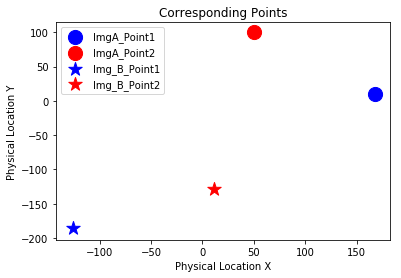

In [9]:
def plot_points(imgA_pt1, imgA_pt2, imgB_pt1, imgB_pt2):
    c = ['b','r']
    pt1 = plt.scatter(imgA_pt1[0],imgA_pt1[1], s=200, c = c[0], marker='o')
    pt2 = plt.scatter(imgA_pt2[0],imgA_pt2[1],s=200, c = c[1], marker='o')
    pt3 = plt.scatter(imgB_pt1[0],imgB_pt1[1], s=200, c = c[0], marker='*')
    pt4 = plt.scatter(imgB_pt2[0],imgB_pt2[1], s=200, c = c[1], marker='*')
    plt.legend((pt1,pt2,pt3,pt4),('ImgA_Point1','ImgA_Point2', 'Img_B_Point1', 'Img_B_Point2'), loc='upper left')
    plt.xlabel('Physical Location X')
    plt.ylabel('Physical Location Y')
    plt.title('Corresponding Points')

imgA_pt1 = np.array([168,10])
imgA_pt2 = np.array([50,100])
imgB_pt1 = np.array([-125.34,-185.49])
imgB_pt2 = np.array([11.60,-128.30])
plot_points(imgA_pt1, imgA_pt2, imgB_pt1, imgB_pt2)

first check that the distance between the two points is the same

In [10]:
print("a dist:", np.linalg.norm(imgA_pt1- imgA_pt2))
print("b dist:", np.linalg.norm(imgB_pt1 - imgB_pt2))

a dist: 148.4048516727132
b dist: 148.4023574610592


The goal of this exercise is to find the Euler2DTransform that transforms the red circle to the red star and the blue circle to the blue star.


There exists a Euler2DTransform defined by the parameters $(T_x, T_y, \theta)$, such that the following holds true for both Point1 and Point2.

$
\begin{bmatrix}
  cos\theta & -sin\theta \\
  sin\theta & cos\theta
\end{bmatrix}
\begin{bmatrix}
  X_A\\
  Y_A
\end{bmatrix}
+
\begin{bmatrix}
  T_x \\
  T_y
\end{bmatrix}
=
\begin{bmatrix}
  X_B \\
  Y_B
\end{bmatrix}
$

Calculate the Euler2DTransform by solving for $(T_x, T_y, \theta)$


 You need to carfully consider what a rotation of $\theta$ means in your example.



HINT:

There are multiple ways to solve this problem.

You could set up a system of 4 equations with 4 unknowns, and solve for the unknowns: $T_x$, $T_y$, $m$, and $n$ (where $m=cos\theta$ and $n=sin\theta$)

Or you could use trigonometric calculations, given the angle $\theta$ between two vectors $u$ and $v$ is given by

$cos \theta = \frac{u \cdot v}{ ||u||*||v||}$




In [11]:
# Option 1. Shift and Rotate
# align pt1 in both images
diff_pt1s = imgB_pt1 - imgA_pt1 
moved_A_pt1 = imgA_pt1 + diff_pt1s
moved_A_pt2 = imgA_pt2 + diff_pt1s
print("Translate A :", diff_pt1s)

Translate A : [-293.34 -195.49]


In [12]:
print("New Points After Translation:")
print("A Points: ", moved_A_pt1, moved_A_pt2)
print("B Points: ", imgB_pt1, imgB_pt2)

New Points After Translation:
A Points:  [-125.34 -185.49] [-243.34  -95.49]
B Points:  [-125.34 -185.49] [  11.6 -128.3]


In [13]:
# Center the points, so that the rotation happens around the correct axis
translation_to_center = -1 * moved_A_pt1
centered_A_pt1 = moved_A_pt1 + translation_to_center
centered_A_pt2 = moved_A_pt2 + translation_to_center
centered_B_pt1 = imgB_pt1 + translation_to_center
centered_B_pt2 = imgB_pt2 + translation_to_center
print("Fixed Centering Translation Parmeter: ", translation_to_center)

Fixed Centering Translation Parmeter:  [125.34 185.49]


In [14]:
print("New Points After Translation:")
print("A Points: ", centered_A_pt1, centered_A_pt2)
print("B Points: ", centered_B_pt1, centered_B_pt2)

New Points After Translation:
A Points:  [0. 0.] [-118.   90.]
B Points:  [2.84217094e-14 0.00000000e+00] [136.94  57.19]


In [15]:
v = centered_A_pt2 - centered_A_pt1
u = centered_B_pt2 - centered_B_pt1
theta = np.arccos(np.dot(u, v)/ (np.linalg.norm(u)*np.linalg.norm(v)))
print("theta =", theta)

theta = 2.0943953685573837


In [16]:
rotation_matrix = np.array([
    [np.cos(theta),-1*np.sin(theta)],
    [np.sin(theta),np.cos(theta)]
])
print("rotation matrix: ")
pprint.pprint(rotation_matrix)

rotation matrix: 
array([[-0.50000023, -0.86602527],
       [ 0.86602527, -0.50000023]])


In [17]:
new_A_pt2 = np.matmul(centered_A_pt2, rotation_matrix)

In [18]:
print("New Points After Rotation:")
print("A Points: ", centered_A_pt1, new_A_pt2)
print("B Points: ", centered_B_pt1, centered_B_pt2)

New Points After Rotation:
A Points:  [0. 0.] [136.94230156  57.1909612 ]
B Points:  [2.84217094e-14 0.00000000e+00] [136.94  57.19]


<b>Fill in each X.X with your solution</b>

$
\begin{bmatrix}
  T_x \\
  T_y
\end{bmatrix}
= 
\begin{bmatrix} 
    -293.34 \\
    -195.49
\end{bmatrix}$

$\theta= 2.0943953$ radians 

Fixed Parameters:      
Center_of_rotation = [-125.34, -185.49]



Origional State:


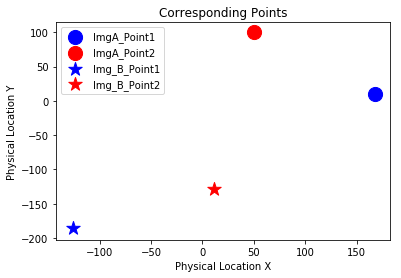

Translate A:


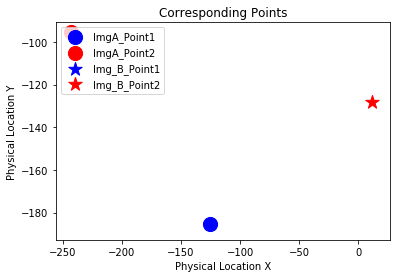

Rotation is set about the center:


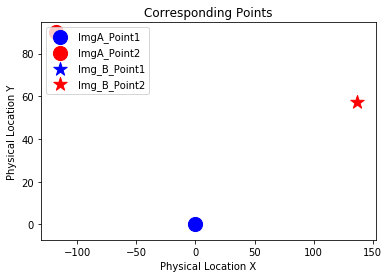

Rotation A:


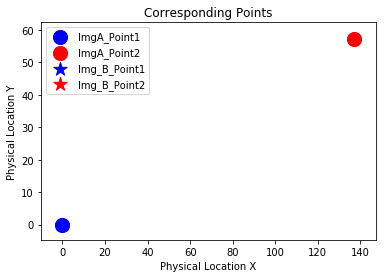

Final State:


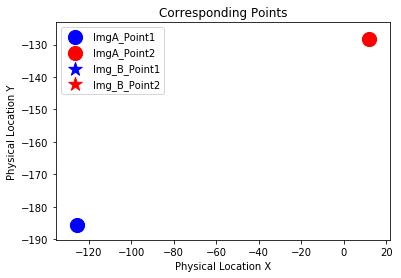

In [19]:
# Evaluation (use the parameters defined to manipulate imageA into imageB):
T_translation = diff_pt1s
theta = 2.0943953
rotation_matrix = np.array([
    [np.cos(theta),-1*np.sin(theta)],
    [np.sin(theta),np.cos(theta)]
])
T_centering = translation_to_center


imgA_pt1 = np.array([168,10])
imgA_pt2 = np.array([50,100])
imgB_pt1 = np.array([-125.34,-185.49])
imgB_pt2 = np.array([11.60,-128.30])
print("Origional State:")
plot_points(imgA_pt1, imgA_pt2, imgB_pt1, imgB_pt2)
plt.show()

eval_im_A_pt1 = imgA_pt1 + T_translation
eval_im_A_pt2 = imgA_pt2 + T_translation

print("Translate A:")
plot_points(eval_im_A_pt1, eval_im_A_pt2, imgB_pt1, imgB_pt2)
plt.show()

eval_im_A_pt1 = eval_im_A_pt1 + T_centering
eval_im_A_pt2 = eval_im_A_pt2 + T_centering
eval_im_B_pt1 = imgB_pt1 + T_centering
eval_im_B_pt2 = imgB_pt2 + T_centering

print("Rotation is set about the center:")
plot_points(eval_im_A_pt1, eval_im_A_pt2, eval_im_B_pt1, eval_im_B_pt2)
plt.show()

eval_im_A_pt1 = np.matmul(eval_im_A_pt1, rotation_matrix)
eval_im_A_pt2 = np.matmul(eval_im_A_pt2, rotation_matrix)

print("Rotation A:")
plot_points(eval_im_A_pt1, eval_im_A_pt2, eval_im_B_pt1, eval_im_B_pt2)
plt.show()

eval_im_A_pt1 = eval_im_A_pt1 - T_centering
eval_im_A_pt2 = eval_im_A_pt2 - T_centering
eval_im_B_pt1 = imgB_pt1 - T_centering
eval_im_B_pt2 = imgB_pt2 - T_centering

print("Final State:")
plot_points(eval_im_A_pt1, eval_im_A_pt2, imgB_pt1, imgB_pt2)
plt.show()

# Apply Transform
Write a transform_image widget that takes in an image, a reference image, and the Euler2DTransform parameters $(T_x, T_y, \theta)$ and displays the transformed image. There should be a widget bar for each parameter. Use this graphical interface to transform imageB_2D to imageA_2D, carefully consider what the reference image to make this transform. Record the parameters $(T_x, T_y, \theta)$ that give the transformation.

HINT: parameter ranges

$T_x$: (-100.0,100.0,5.0)
   
$T_y$: (-100.0,100.0,5.0)
  
$\theta$: (-180.0,180.0,5.0)

In [20]:
# define widget sliders
t_x_slider = FloatSlider(
    value=-41.6,
    min=-100.0,
    max=100.0,
    step=0.1,
    description='Translate(x):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

t_y_slider = FloatSlider(
    value=-100,
    min=-100.0,
    max=100.0,
    step=0.1,
    description='Translate(y):',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

theta_slider = FloatSlider(
    value=-120.5,
    min=-180.0,
    max=180.0,
    step=0.1,
    description='Theta:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)  

In [21]:
# image setup
PixelType = itk.F
Dimension = 2
ImageType = itk.Image[PixelType, Dimension]
reader = itk.ImageFileReader[ImageType].New()

reader.SetFileName(join(data_dir, imageA_2d_fn))
reader.Update()
imageA_2d = reader.GetOutput()

reader.SetFileName(join(data_dir, imageB_2d_fn))
reader.Update()
imageB_2d = reader.GetOutput()

In [22]:
# Utility function to resample an image by applying a transform
 
def transform_image(image, ref_image, transform):
    """ Apply a resampling to the reference image using a CosineWindowedSinc interpolator.
    
    Args:
        image (itk.Image): the image to transform
        ref_image (itk.Image): The reference image used for resampling
        transform (itk.Image): the transform to apply 
    Returns:
        out_img (itk.Image): the transformed image
        
    """
    size = ref_image.GetLargestPossibleRegion().GetSize()
    spacing = ref_image.GetSpacing()
    origin = ref_image.GetOrigin()
    
    resamplerType = itk.ResampleImageFilter[ImageType, ImageType]
    resampleFilter = resamplerType.New()
    # I could not find the python api version of windowed sinc, so i am using linear
    interpolator = itk.NearestNeighborInterpolateImageFunction[ImageType, itk.D].New() 
    
    resampleFilter.SetInput(image)
    resampleFilter.SetTransform(transform)
    resampleFilter.SetInterpolator(interpolator)
    resampleFilter.SetSize(size)
    resampleFilter.SetOutputSpacing(spacing)
    resampleFilter.SetOutputOrigin(origin)
    resampleFilter.Update()
    return resampleFilter.GetOutput()
                                
    
def intermediate_interact_func(t_x, t_y, theta):
    #diff_image = itk.subtract_image_filter(image_one, image_two)
    my_transform = itk.Euler2DTransform[itk.D].New()
    my_transform.SetAngleInDegrees(theta)
    my_transform.SetTranslation([t_x, t_y])
    trans_image = transform_image(imageA_2d, imageB_2d, my_transform)
    plt.imshow(itk.GetArrayViewFromImage(trans_image) - itk.GetArrayViewFromImage(imageB_2d))
    plt.show() # I am not sure if this visualizaion will cause users to register in voxel space
#     difference_op = itk.SubtractImageFilter[ImageType, ImageType, ImageType].New()
#     difference_op.SetInput1(imageB_2d)
#     difference_op.SetInput2(trans_image)
#     difference_op.Update()
#     result_image = difference_op.GetOutput()
#     plt.imshow(itk.GetArrayViewFromImage(result_image))
#     plt.show()

interact(intermediate_interact_func, t_x=t_x_slider, t_y=t_y_slider, theta=theta_slider)

interactive(children=(FloatSlider(value=-41.6, continuous_update=False, description='Translate(x):', min=-100.…

<function __main__.intermediate_interact_func(t_x, t_y, theta)>

### Best parameters I could find:
$T_x = -41.6 $     
$T_y = -100 $     
$\Theta = -120.5$    